# Hands-on time

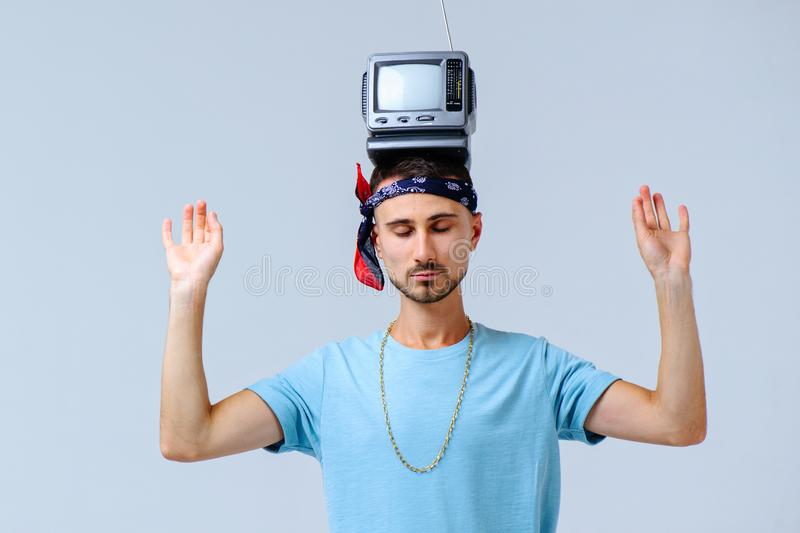

In this lab we'll follow the next steps:
1. Downnload data using Yahoo Finance API
2. Explore and analyze data
3. Learn how to deal with forecasting models - Prophet

In [68]:
# *IMPORT LIBRARIES USED*

!pip install prophet
!pip install yfinance

from prophet import Prophet
from datetime import date
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

**yfinance**

"Ever since Yahoo! finance decommissioned their historical data API, many programs that relied on it to stop working.

yfinance aimes to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance."

https://pypi.org/project/yfinance/

# 1. Download data

Definition of an analysis starting and ending period

In [69]:
start = pd.to_datetime('2010-01-01')
end = date.today()
#custom_end = pd.to_datetime('2022-05-22')
#end = custom_end

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definition of a list of Ticker: in yfinance you need to specify the rate needed in the following format:  't_currency1t_currency2=X'.

In [71]:
start

Timestamp('2010-01-01 00:00:00')

In [72]:
# In yfinance
tickers_to_download = ['EURUSD=X', 'GBPUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURJPY=X', 'USDCAD=X', 'AUDUSD=X']

Download the previous tickers only for Close prices

In [73]:
forex_df_list = []

for ticker in tickers_to_download:
  ts = yf.download(ticker, start, end)['Close']
  ts = ts.rename(ticker.lower().split('=', 1)[0] + '_close')
  forex_df_list.append(ts)

forex_df = pd.concat(forex_df_list, axis=1)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [74]:
forex_df

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-01      1.438994      1.613294       1.03390     92.919998   
2010-01-04      1.442398      1.611370       1.02910     92.495003   
2010-01-05      1.436596      1.599079       1.03370     91.584999   
2010-01-06      1.440403      1.602384       1.02760     92.356003   
2010-01-07      1.431803      1.593397       1.03360     93.389999   
...                  ...           ...           ...           ...   
2024-05-31      1.083541      1.273042       0.90331    156.953003   
2024-06-03      1.085305      1.274372       0.90132    157.179993   
2024-06-04      1.090739      1.281017       0.89502    156.076004   
2024-06-05      1.088187      1.277302       0.88995    155.123993   
2024-06-06      1.087453      1.279476       0.89250    155.929001   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-01    133.710007       1.05120      0.898473  
2010-01-04    133.389999       1.04100      0.912492  
2010-01-05    131.529999       1.03950      0.911826  
2010-01-06    133.013000       1.03190      0.920471  
2010-01-07    133.748001       1.03400      0.917768  
...                  ...           ...           ...  
2024-05-31    169.996002       1.36833      0.663030  
2024-06-03    170.580002       1.36189      0.665690  
2024-06-04    170.227997       1.36287      0.669008  
2024-06-05    168.796005       1.36762      0.664620  
2024-06-06    169.556000       1.36900      0.665779  

[3763 rows x 7 columns]

# 2. Data exploration

### Check missing values and fill if needed

In [75]:
# nan values do exist
forex_df[forex_df.isnull().any(axis=1)]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-15      1.443210           NaN           NaN           NaN   
2012-01-27      1.309278      1.568209           NaN     77.459999   
2012-01-31      1.313957      1.570845           NaN     76.360001   
2012-12-04           NaN      1.609787           NaN     82.133003   
2013-10-08           NaN           NaN           NaN           NaN   
2019-05-22           NaN           NaN           NaN           NaN   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-15           NaN           NaN           NaN  
2012-01-27    101.421997        1.0024      1.061582  
2012-01-31    100.330002        1.0024      1.058604  
2012-12-04    107.301003           NaN           NaN  
2013-10-08    131.289993           NaN           NaN  
2019-05-22    123.438004           NaN           NaN

In [76]:
sentiment_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/sentiment.csv")
sentiment_df

date  negative   neutral  positive
0     01-01-2021  0.045591  0.347507  0.002401
1     01-01-2021  0.010174  0.233930  0.006298
2     01-01-2024  0.000055  0.985181  0.010035
3     01-01-2024  0.000189  0.999684  0.000021
4     01-02-2021  0.001550  0.841206  0.002725
...          ...       ...       ...       ...
2126  31-10-2023  0.002908  0.985406  0.000067
2127  31-12-2020  0.000833  0.208067  0.131062
2128  31-12-2020  0.054524  0.350759  0.003904
2129  31-12-2021  0.000121  0.979307  0.003975
2130  31-12-2021  0.001654  0.758539  0.005909

[2131 rows x 4 columns]

Multiple strategies can be used to fill missing values, these depend on the nature of the problem (but be aware of the consequences):

- use median, mode, mean values
- use a statistical method: regression, nearest neighbors
- back/forward fill, **interpolate**
- drop missing data

In [77]:
# fillna fills with given value or method: in this case forward fill
forex_df.fillna(method='ffill', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-15 00:00:00, dtype: float64

In [78]:
forex_df.loc['2011-04-14']

eurusd_close      1.444210
gbpusd_close      1.626889
usdchf_close      0.895900
usdjpy_close     83.782997
eurjpy_close    121.000000
usdcad_close      0.962600
audusd_close      1.049803
Name: 2011-04-14 00:00:00, dtype: float64

In [79]:
# interpolate interpolates given a method
forex_df.interpolate(method='linear', axis=0).loc['2011-04-15']

eurusd_close      1.443210
gbpusd_close      1.629145
usdchf_close      0.894250
usdjpy_close     83.465000
eurjpy_close    120.417999
usdcad_close      0.961300
audusd_close      1.053002
Name: 2011-04-15 00:00:00, dtype: float64

In [80]:
forex_df.loc[['2011-04-14', '2011-04-15', '2011-04-18']]

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2011-04-14      1.444210      1.626889        0.8959     83.782997   
2011-04-15      1.443210           NaN           NaN           NaN   
2011-04-18      1.441296      1.631401        0.8926     83.147003   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2011-04-14    121.000000        0.9626      1.049803  
2011-04-15           NaN           NaN           NaN  
2011-04-18    119.835999        0.9600      1.056201

In [81]:
# let's use interpolation since we are dealing with time series data
forex_df.interpolate(method='linear', axis=0, inplace=True)
# double check on missing data
forex_df[forex_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [eurusd_close, gbpusd_close, usdchf_close, usdjpy_close, eurjpy_close, usdcad_close, audusd_close]
Index: []

In [82]:
forex_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3763 entries, 2010-01-01 to 2024-06-06
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eurusd_close  3763 non-null   float64
 1   gbpusd_close  3763 non-null   float64
 2   usdchf_close  3763 non-null   float64
 3   usdjpy_close  3763 non-null   float64
 4   eurjpy_close  3763 non-null   float64
 5   usdcad_close  3763 non-null   float64
 6   audusd_close  3763 non-null   float64
dtypes: float64(7)
memory usage: 364.2 KB


In [83]:
forex_df.describe()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  eurjpy_close  \
count   3763.000000   3763.000000   3763.000000   3763.000000   3763.000000   
mean       1.194459      1.415017      0.949479    108.512054    127.924484   
std        0.114127      0.152307      0.051317     18.666403     14.335020   
min        0.959619      1.072754      0.722800     75.739998     94.209999   
25%        1.101758      1.279902      0.913895     98.945000    119.519001   
50%        1.164687      1.380110      0.949700    108.902000    128.358002   
75%        1.298802      1.561683      0.984500    115.553001    135.629005   
max        1.484406      1.716090      1.162700    158.223999    170.654007   

       usdcad_close  audusd_close  
count   3763.000000   3763.000000  
mean       1.213148      0.807336  
std        0.140542      0.131494  
min        0.943200      0.574290  
25%        1.049125      0.708761  
50%        1.273100      0.759301  
75%        1.326870      0.920810  
max        1.457800      1.103497

### Visualize data

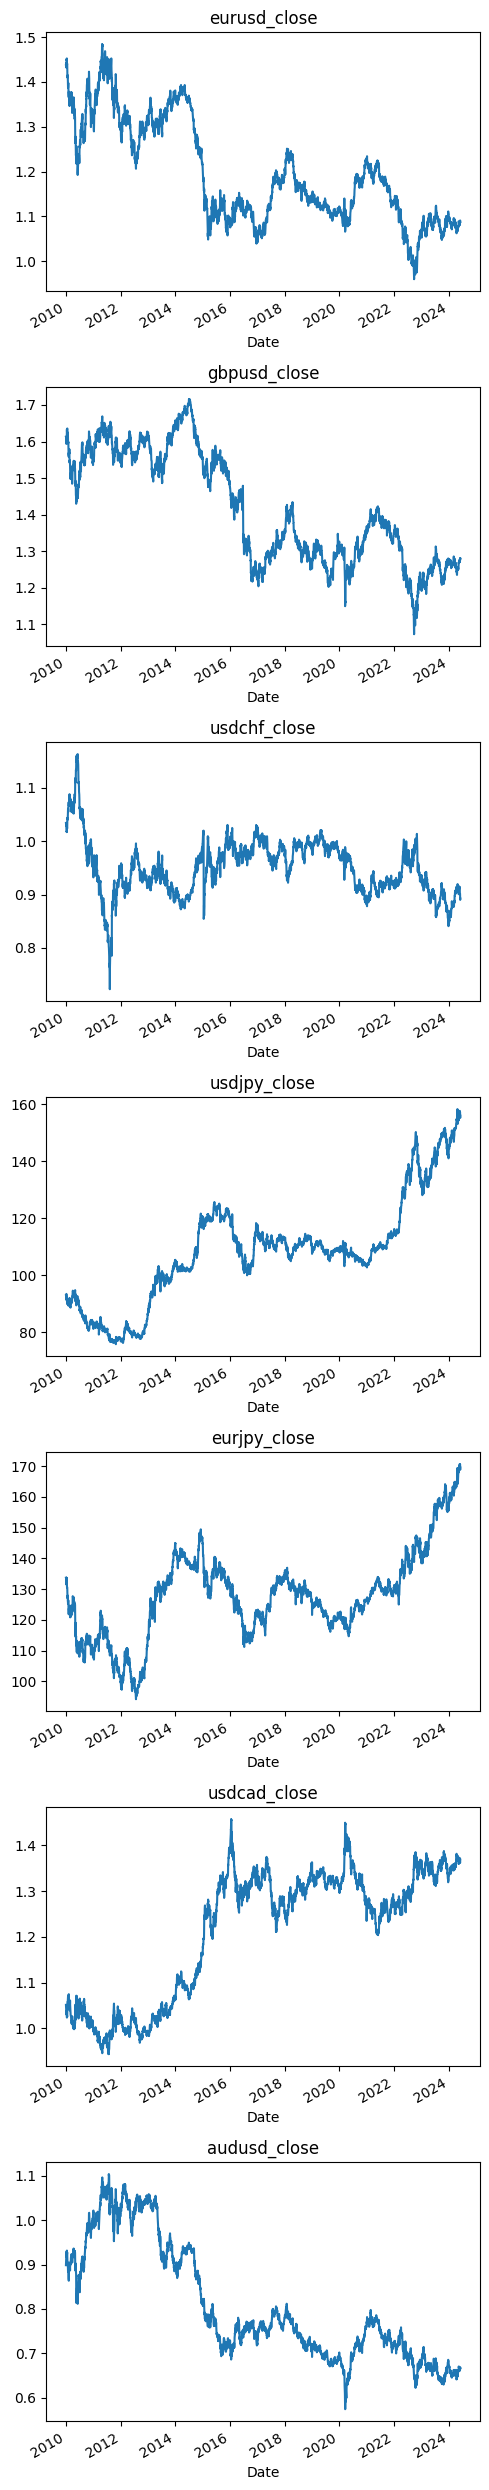

In [84]:
fig, ax = plt.subplots(forex_df.shape[1],1, figsize=(5,25))
for idx, col in enumerate(forex_df):
  forex_df[col].plot(ax=ax[idx])
  ax[idx].set_title(col)
fig.tight_layout()

In [85]:
# Looking for something fancier? go for plotly :-)

for idx, col in enumerate(forex_df):
  fig = px.line(forex_df, y=col)
  fig.show()

Scaling the changes using by percentange change, in order to remove differences between pricing, scaling is also vital to perform the Value at Risk calculation and for a statistical analysis.

1. For risk analysis we are more interested in daily changes than in the absolute value of the rate. (e.g. for VaR analysis)

In [86]:
forex_rate_df = forex_df.pct_change(axis='rows')
forex_rate_df_clean = forex_rate_df.dropna(axis=0)

In [87]:
# New Dataframe cleaned
forex_rate_df_clean

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-04      0.002366     -0.001192     -0.004643     -0.004574   
2010-01-05     -0.004022     -0.007628      0.004470     -0.009838   
2010-01-06      0.002650      0.002067     -0.005901      0.008418   
2010-01-07     -0.005971     -0.005609      0.005839      0.011196   
2010-01-08      0.006499      0.005657     -0.009675     -0.007817   
...                  ...           ...           ...           ...   
2024-05-31      0.003110      0.002554     -0.010397     -0.004156   
2024-06-03      0.001628      0.001045     -0.002203      0.001446   
2024-06-04      0.005006      0.005214     -0.006990     -0.007024   
2024-06-05     -0.002340     -0.002899     -0.005665     -0.006100   
2024-06-06     -0.000674      0.001702      0.002865      0.005189   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-04     -0.002393     -0.009703      0.015604  
2010-01-05     -0.013944     -0.001441     -0.000729  
2010-01-06      0.011275     -0.007311      0.009481  
2010-01-07      0.005526      0.002035     -0.002937  
2010-01-08     -0.001929     -0.004062      0.007956  
...                  ...           ...           ...  
2024-05-31     -0.001292     -0.002457      0.002510  
2024-06-03      0.003435     -0.004706      0.004012  
2024-06-04     -0.002064      0.000720      0.004984  
2024-06-05     -0.008412      0.003485     -0.006559  
2024-06-06      0.004502      0.001009      0.001744  

[3762 rows x 7 columns]

Aggregated Returns plot

In [88]:
fig = go.Figure()

for ticker in forex_rate_df_clean.columns:

  # Only thing I figured is - I could do this
  fig.add_scatter(
                  x=forex_rate_df_clean.index,
                  y=forex_rate_df_clean[f'{ticker}'],
                  name=f'{ticker}'
                ) # Not what is desired - need a line

# Show plot
fig.show()

### Standard Deviation of the different rates of returns.

In [89]:
for ticker in forex_rate_df_clean.columns:
  fig = px.histogram(forex_rate_df_clean, x=ticker,
                    marginal="rug", template="plotly_white",
                    hover_data=forex_rate_df_clean.columns,
                    title=f'Distribution of {ticker} the std related to it is {np.round(forex_rate_df_clean[ticker].std(), 3)}')
  fig.show()

Correlation analysis between numerical variables.

In [90]:
forex_rate_df_clean.corr()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
eurusd_close      1.000000      0.606514     -0.621863     -0.297052   
gbpusd_close      0.606514      1.000000     -0.408188     -0.211593   
usdchf_close     -0.621863     -0.408188      1.000000      0.387546   
usdjpy_close     -0.297052     -0.211593      0.387546      1.000000   
eurjpy_close      0.559105      0.312559     -0.172129      0.623687   
usdcad_close     -0.465043     -0.461405      0.283140      0.082233   
audusd_close      0.558406      0.546074     -0.376516     -0.198133   

              eurjpy_close  usdcad_close  audusd_close  
eurusd_close      0.559105     -0.465043      0.558406  
gbpusd_close      0.312559     -0.461405      0.546074  
usdchf_close     -0.172129      0.283140     -0.376516  
usdjpy_close      0.623687      0.082233     -0.198133  
eurjpy_close      1.000000     -0.311689      0.284862  
usdcad_close     -0.311689      1.000000     -0.687495  
audusd_close      0.284862     -0.687495      1.000000

In [91]:
fig = px.scatter_matrix(forex_rate_df_clean,
                        dimensions=forex_rate_df_clean.columns.to_list(),
                        height=1000, width=1000,
                        template='plotly_white'
                        )

fig.update_traces(diagonal_visible=False)
fig.show()

### Pearson Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

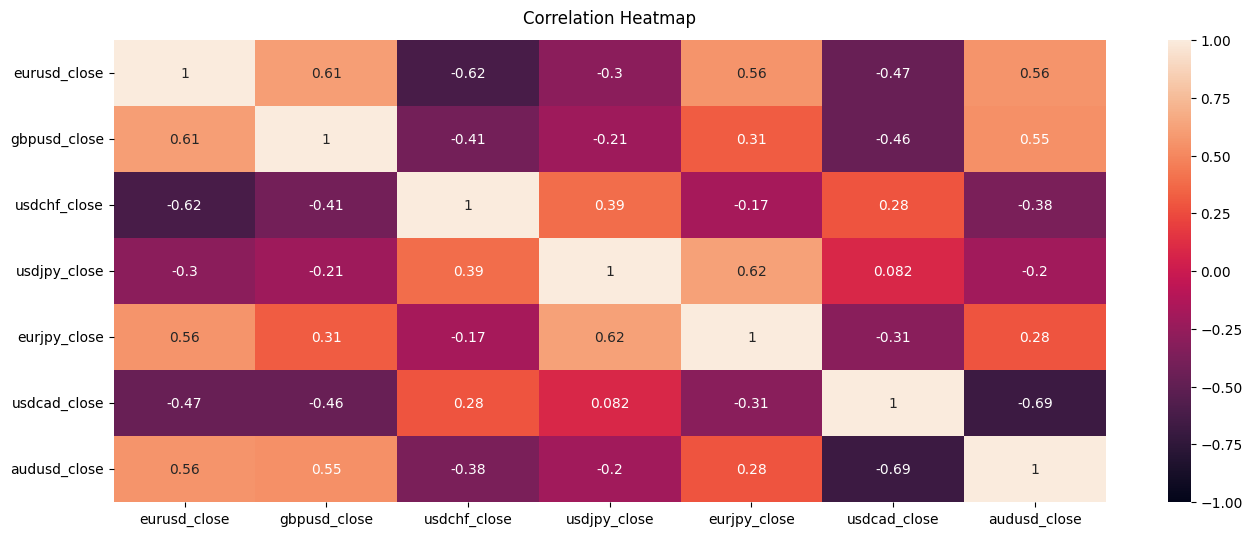

In [92]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(forex_rate_df_clean.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# 3. Forecasting Method - Prophet

Prophet is a library developed by Facebook for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well (Facebook-Prophet website: https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,daily%20seasonality%2C%20plus%20holiday%20effects.&text=Prophet%20is%20open%20source%20software,download%20on%20CRAN%20and%20PyPI.)

In order to forecast the SINGLE series in the future we need to:
1. ALWAYS add an additional column related to the y variable (in our scenario equal to eurgbp_close) to df['y']
2. ALWAYS Reset the index of the series and rename the column with the date in df['ds']

In [93]:
forex_df

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2010-01-01      1.438994      1.613294       1.03390     92.919998   
2010-01-04      1.442398      1.611370       1.02910     92.495003   
2010-01-05      1.436596      1.599079       1.03370     91.584999   
2010-01-06      1.440403      1.602384       1.02760     92.356003   
2010-01-07      1.431803      1.593397       1.03360     93.389999   
...                  ...           ...           ...           ...   
2024-05-31      1.083541      1.273042       0.90331    156.953003   
2024-06-03      1.085305      1.274372       0.90132    157.179993   
2024-06-04      1.090739      1.281017       0.89502    156.076004   
2024-06-05      1.088187      1.277302       0.88995    155.123993   
2024-06-06      1.087453      1.279476       0.89250    155.929001   

            eurjpy_close  usdcad_close  audusd_close  
Date                                                  
2010-01-01    133.710007       1.05120      0.898473  
2010-01-04    133.389999       1.04100      0.912492  
2010-01-05    131.529999       1.03950      0.911826  
2010-01-06    133.013000       1.03190      0.920471  
2010-01-07    133.748001       1.03400      0.917768  
...                  ...           ...           ...  
2024-05-31    169.996002       1.36833      0.663030  
2024-06-03    170.580002       1.36189      0.665690  
2024-06-04    170.227997       1.36287      0.669008  
2024-06-05    168.796005       1.36762      0.664620  
2024-06-06    169.556000       1.36900      0.665779  

[3763 rows x 7 columns]

In [94]:
# In order to forecast the series we need to: 1.
# 1)
forex_df['ds'] = forex_df.index
forex_df['y'] = forex_df['eurusd_close'].values

forex_df.tail()

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2024-05-31      1.083541      1.273042       0.90331    156.953003   
2024-06-03      1.085305      1.274372       0.90132    157.179993   
2024-06-04      1.090739      1.281017       0.89502    156.076004   
2024-06-05      1.088187      1.277302       0.88995    155.123993   
2024-06-06      1.087453      1.279476       0.89250    155.929001   

            eurjpy_close  usdcad_close  audusd_close         ds         y  
Date                                                                       
2024-05-31    169.996002       1.36833      0.663030 2024-05-31  1.083541  
2024-06-03    170.580002       1.36189      0.665690 2024-06-03  1.085305  
2024-06-04    170.227997       1.36287      0.669008 2024-06-04  1.090739  
2024-06-05    168.796005       1.36762      0.664620 2024-06-05  1.088187  
2024-06-06    169.556000       1.36900      0.665779 2024-06-06  1.087453

Create train and test, test used in prophet only for backtesting reason!

In [95]:
# define test and train window
train_window =  ['2010-01-03','2020-10-31']
test_window =  ['2020-11-01','2021-06-10']

In [96]:
# create train and test dataset
train = forex_df[train_window[0]:train_window[1]]
test = forex_df[test_window[0]:test_window[1]]


In [97]:
test

eurusd_close  gbpusd_close  usdchf_close  usdjpy_close  \
Date                                                                 
2020-11-02      1.164212      1.292674      0.917160    104.580002   
2020-11-03      1.164280      1.292390      0.918773    104.724998   
2020-11-04      1.176221      1.312164      0.910640    104.545998   
2020-11-05      1.173268      1.296680      0.911400    104.438004   
2020-11-06      1.181754      1.313940      0.904170    103.602997   
...                  ...           ...           ...           ...   
2021-06-04      1.213301      1.410994      0.903500    110.265999   
2021-06-07      1.216841      1.416431      0.899100    109.616997   
2021-06-08      1.219363      1.417656      0.897500    109.274002   
2021-06-09      1.217285      1.414988      0.896800    109.469002   
2021-06-10      1.218200      1.411233      0.895600    109.610001   

            eurjpy_close  usdcad_close  audusd_close         ds         y  
Date                                                                       
2020-11-02    121.744003       1.33679      0.700820 2020-11-02  1.164212  
2020-11-03    121.879997       1.32205      0.705370 2020-11-03  1.164280  
2020-11-04    122.960999       1.31021      0.719683 2020-11-04  1.176221  
2020-11-05    122.530998       1.31264      0.718050 2020-11-05  1.173268  
2020-11-06    122.425003       1.30821      0.726270 2020-11-06  1.181754  
...                  ...           ...           ...        ...       ...  
2021-06-04    133.753006       1.21070      0.766577 2021-06-04  1.213301  
2021-06-07    133.360001       1.20758      0.774400 2021-06-07  1.216841  
2021-06-08    133.179993       1.20867      0.775630 2021-06-08  1.219363  
2021-06-09    133.248001       1.21114      0.773700 2021-06-09  1.217285  
2021-06-10    133.492004       1.21146      0.772950 2021-06-10  1.218200  

[159 rows x 9 columns]

In [98]:
m = Prophet()
m.fit(train[['ds', 'y']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/6sgy39x2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/j4s9isfe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62161', 'data', 'file=/tmp/tmppxxw5525/6sgy39x2.json', 'init=/tmp/tmppxxw5525/j4s9isfe.json', 'output', 'file=/tmp/tmppxxw5525/prophet_modeluxecuky1/prophet_model-20240607140409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:04:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [99]:
future = m.make_future_dataframe(20, freq='B')

In [100]:
future = m.make_future_dataframe(20, freq='B') # Explain B with https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
forecast = m.predict(future)

forecast_results = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)
forecast_results.set_index('ds', inplace=True)

<Axes: xlabel='ds'>

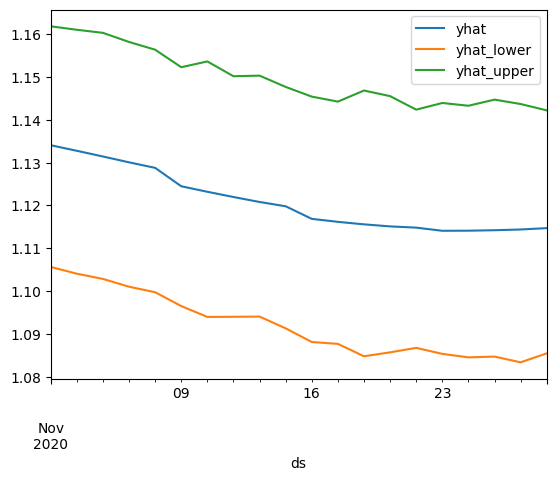

In [101]:
forecast_results.plot()

In [102]:
final_df_results = pd.merge(test[['eurusd_close']], forecast_results[['yhat']], left_index=True, right_index=True, how='inner')

In [103]:
final_df_results

eurusd_close      yhat
2020-11-02      1.164212  1.134049
2020-11-03      1.164280  1.132752
2020-11-04      1.176221  1.131420
2020-11-05      1.173268  1.130057
2020-11-06      1.181754  1.128765
2020-11-09      1.189301  1.124468
2020-11-10      1.182732  1.123184
2020-11-11      1.181879  1.121960
2020-11-12      1.178030  1.120798
2020-11-13      1.180339  1.119797
2020-11-16      1.184525  1.116856
2020-11-17      1.185944  1.116160
2020-11-18      1.186366  1.115577
2020-11-19      1.184764  1.115098
2020-11-20      1.186648  1.114810
2020-11-23      1.186648  1.114075
2020-11-24      1.184273  1.114097
2020-11-25      1.190051  1.114204
2020-11-26      1.192000  1.114377
2020-11-27      1.191600  1.114694

## Model evaluation and scores

In [104]:
# Errors
def calc_errors(test, preds):
    percentiles = [5, 25, 50, 75, 95]
    elementwise_mae = np.absolute(np.subtract(preds, test))
    # Mean mae https://en.wikipedia.org/wiki/Mean_absolute_error
    mean_mae = sum(elementwise_mae) / len(test)
    print(f"Mean MAE: {mean_mae:.2f}")
    percent_mae = sum(elementwise_mae) / sum(test)
    print(f"MAE%: {percent_mae * 100:.2f}%")
    # Rmse https://en.wikipedia.org/wiki/Root-mean-square_deviation
    rmse = np.sqrt(np.mean(np.power(np.subtract(preds, test), 2)))
    print(f"RMSE: {rmse:.2f}")
    # Bias https://en.wikipedia.org/wiki/Bias_(statistics)
    bias = np.mean(np.subtract(preds, test))
    print(f"Bias: {bias:.2f}\n")
    # Mae distrib
    distr_mae = []
    for perc in percentiles:
        temp_mae = np.percentile(elementwise_mae, perc)
        distr_mae.append(temp_mae)
        print(f"{perc}th percetile MAE: {temp_mae:.2f}")
    # Plot MAE distribution
    plt.figure(figsize=(8, 8))
    plt.title('MAE distribution')
    plt.xlabel('MAE')
    plt.ylabel('Count')
    # Plot distr
    plt.hist(elementwise_mae, bins=30)
    # plot mean MAE
    plt.axvline(x=mean_mae, label='Mean MAE', c='r', linestyle='-')
    # plot percentiles
    line_types = [':', '-.', '--', '-.', ':']
    for xc, lt, p in zip(distr_mae, line_types, percentiles):
        plt.axvline(x=xc, label='{}th percentile MAE'.format(p), c='r', linestyle=lt)
    plt.legend()
    plt.show()


In [105]:
final_df_results.describe()

eurusd_close       yhat
count     20.000000  20.000000
mean       1.182242   1.120860
std        0.007831   0.007059
min        1.164212   1.114075
25%        1.179762   1.114781
50%        1.184399   1.118326
75%        1.186648   1.125542
max        1.192000   1.134049

Mean MAE: 0.06
MAE%: 5.19%
RMSE: 0.06
Bias: -0.06

5th percetile MAE: 0.03
25th percetile MAE: 0.06
50th percetile MAE: 0.07
75th percetile MAE: 0.07
95th percetile MAE: 0.08


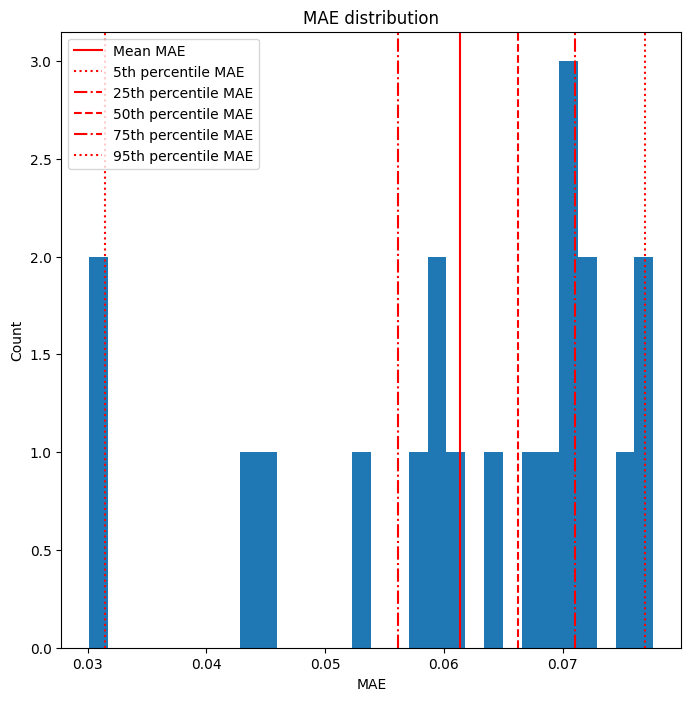

In [106]:
# Analyze the forecast error
calc_errors(final_df_results['eurusd_close'].values, final_df_results['yhat'].values)


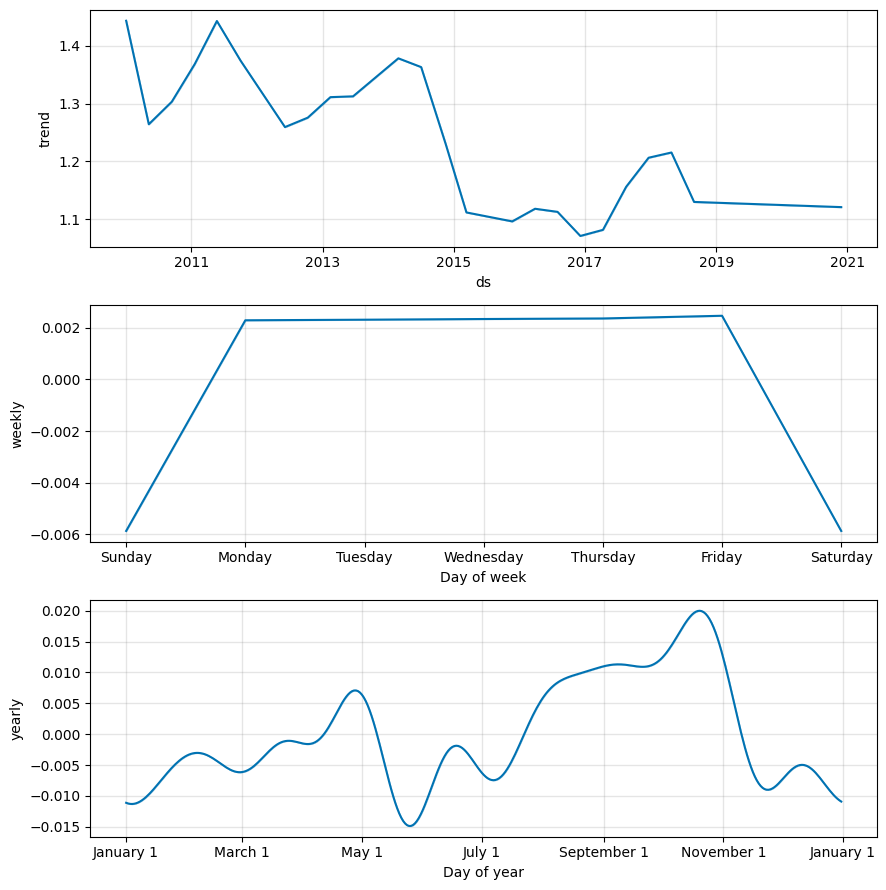

In [107]:
# explore the components of the fitted model
fig = m.plot_components(forecast)

In [108]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['eurusd_close'],
                    mode='lines+markers',
                    name='Real Values'))

fig.add_trace(go.Scatter(x=final_df_results.index, y=final_df_results['yhat'],
                    mode='lines+markers',
                    name='Predicted Values'))

fig.update_layout(template='plotly_white')
fig.show()

### Short long story: work hard for nothing

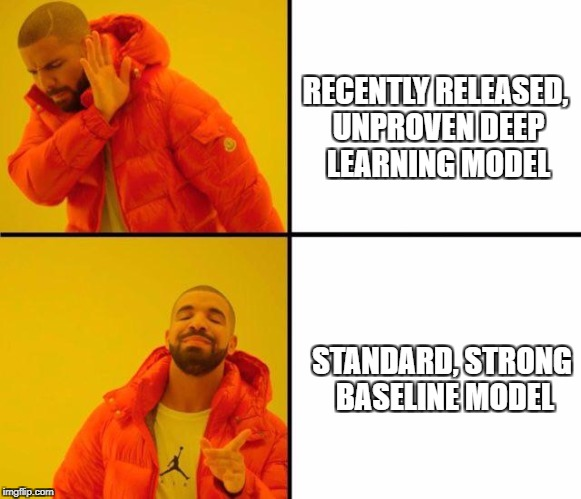

Let's have a look if "stupid" model is able to make better prediction than our method. We are going to shift the value of EURUSD change and use the value of 7 days ago to predict the value of EURUSD for tomorrow

In [109]:
final_df_results


eurusd_close      yhat
2020-11-02      1.164212  1.134049
2020-11-03      1.164280  1.132752
2020-11-04      1.176221  1.131420
2020-11-05      1.173268  1.130057
2020-11-06      1.181754  1.128765
2020-11-09      1.189301  1.124468
2020-11-10      1.182732  1.123184
2020-11-11      1.181879  1.121960
2020-11-12      1.178030  1.120798
2020-11-13      1.180339  1.119797
2020-11-16      1.184525  1.116856
2020-11-17      1.185944  1.116160
2020-11-18      1.186366  1.115577
2020-11-19      1.184764  1.115098
2020-11-20      1.186648  1.114810
2020-11-23      1.186648  1.114075
2020-11-24      1.184273  1.114097
2020-11-25      1.190051  1.114204
2020-11-26      1.192000  1.114377
2020-11-27      1.191600  1.114694

In [110]:
final_df_results['yhat_baselinemodel'] = final_df_results['eurusd_close'].rolling(7).mean()

Mean MAE: 0.00
MAE%: 0.25%
RMSE: 0.00
Bias: 0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.00
50th percetile MAE: 0.00
75th percetile MAE: 0.00
95th percetile MAE: 0.01


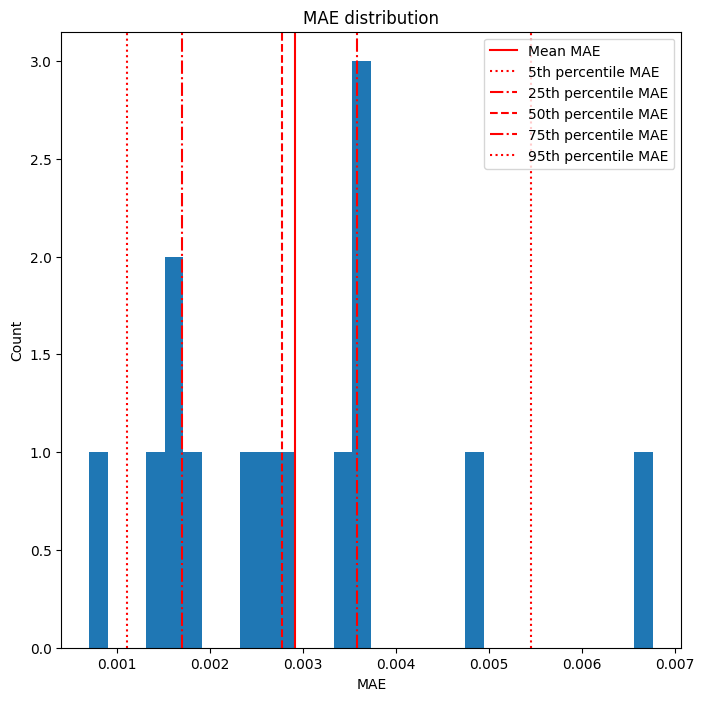

In [111]:
# Analyze the forecast error
calc_errors(final_df_results.dropna()['yhat_baselinemodel'].values, final_df_results.dropna()['eurusd_close'].values)


## Improve forecasting perfomances : hyperparameter tuning and extra regressors

### Load useful data

What's the influence of external forces on FOREX?

We have dowload different timeseries that could have influenced the FOREX. It's clear that the use of these regressors to improve the forecasting performances increases the complexity of the model.

i.e. Let's say that we would like to forecast FOREX in the horizon May 2021 - Jan 2022. The values of extra regressor should be known, which means that other ML models should be use to forecast for example US GDP

Here we studied the effect of GDP, inflation and consumer price index on FOREX. Raw data where download from https://fred.stlouisfed.org/

### What about COVID-19?

Is the global vaccination race the new force in FX markets? – Special Report

https://www.xm.com/is-the-global-vaccination-race-the-new-force-in-fx-markets-special-report-135646

2020 and 2021 have been affected by COVID-19 pandemic. We all know the effect of the pandemic on daily life and economics. Starting from the first days of 2021, vaccinations and growth perspective have influenced a slow restart of "normal" life and therefore of economy.

Here we explore the effect of covid and vaccinations on FOREX. Data were download from https://github.com/owid/covid-19-data

In [112]:
# To load data from your google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change the directory below using the one you have loaded the data in

In [113]:
%cd /content/drive/MyDrive/Colab_Notebooks/

/content/drive/MyDrive/Colab_Notebooks


In [114]:
df_covid = pd.read_csv('./owid-covid-data.csv', parse_dates=['date'], index_col='date')
extra_df = pd.read_csv('./extra_regressors.csv', parse_dates=['DATE'])

In [115]:
extra_df.isnull().sum()/extra_df.shape[0]

DATE        0.000000
CPIAUCSL    0.000000
GDP         0.000000
T10YIE      0.932754
dtype: float64

In [116]:
extra_df.set_index('DATE',inplace=True)
# remap column name
map_dict = {'CPIAUCSL':'consumer_price_index', 'GDP':'GDP_US', 'T10YIE':'inflation'}
extra_df = extra_df.rename(columns=map_dict)
# group data for each continent and sum the number of new cases
df_covid_g = df_covid.groupby(['continent','date']).agg({'new_cases':'sum'})


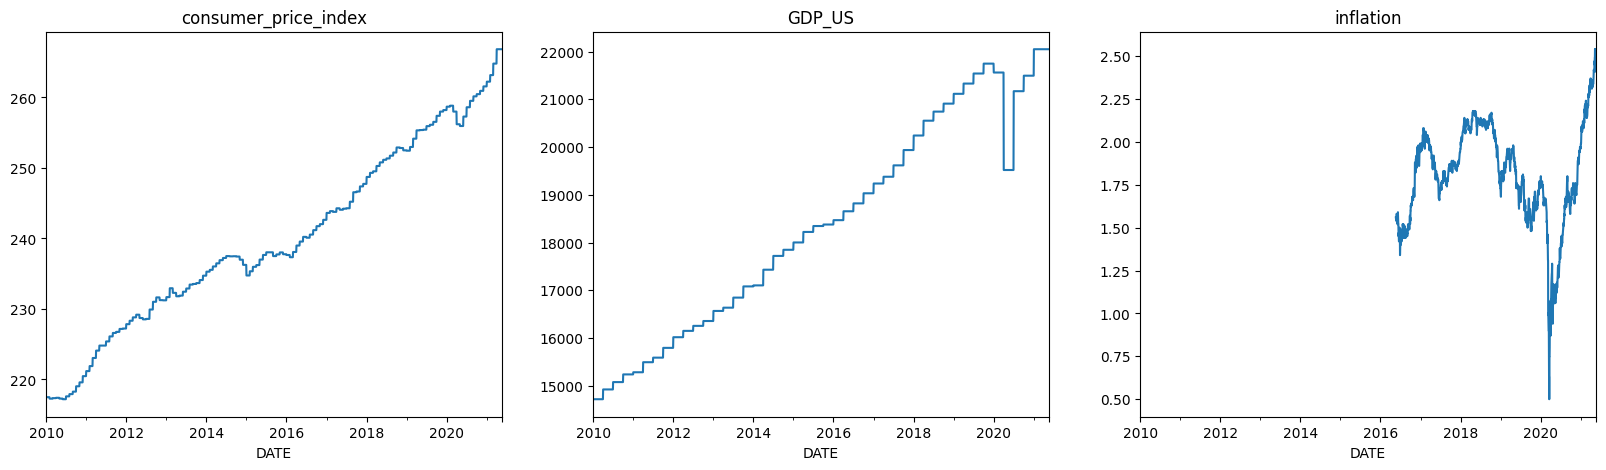

In [117]:
# plot timeseries
fig, ax = plt.subplots(1,3, figsize=(20,5))
for idx, col in enumerate(extra_df):
  extra_df[col].loc[forex_df.index[0]:forex_df.index[-1]].plot(ax=ax[idx])
  ax[idx].set_title(col)

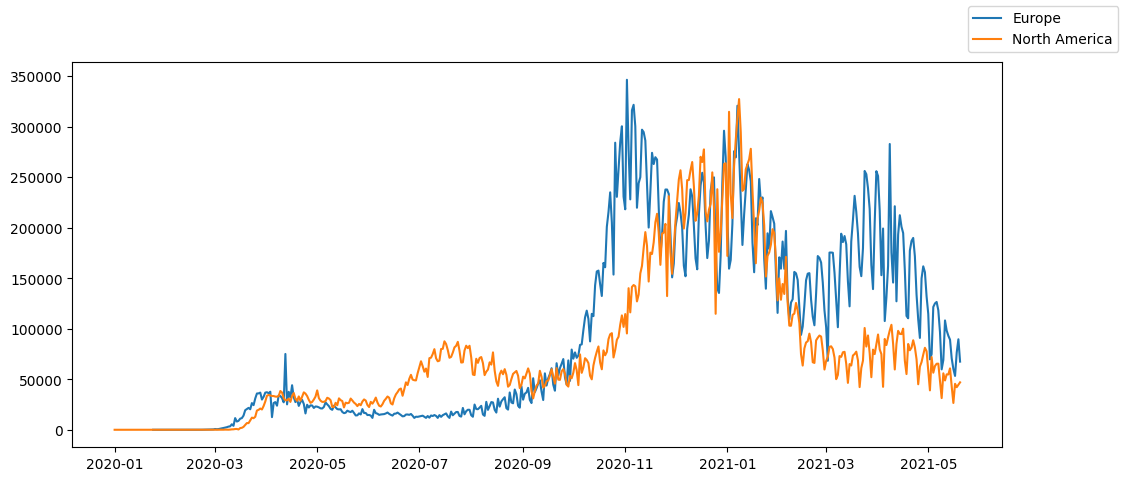

In [118]:
# compare Europe and North America time series
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_covid_g.loc['Europe'], label='Europe')
ax.plot(df_covid_g.loc['North America'], label='North America')
fig.legend()

### Timeseries correlation

# TASK: merge EURUSD data with external regressors and evaluate correlation.
Since you cannot use unavailable data for your prediction, shift all external regressor by two weeks so that you are sure you have all data available

## Solution

In [119]:
EURUSD_data = forex_df[['ds','y']].copy()

In [120]:
EURUSD_data

ds         y
Date                           
2010-01-01 2010-01-01  1.438994
2010-01-04 2010-01-04  1.442398
2010-01-05 2010-01-05  1.436596
2010-01-06 2010-01-06  1.440403
2010-01-07 2010-01-07  1.431803
...               ...       ...
2024-05-31 2024-05-31  1.083541
2024-06-03 2024-06-03  1.085305
2024-06-04 2024-06-04  1.090739
2024-06-05 2024-06-05  1.088187
2024-06-06 2024-06-06  1.087453

[3763 rows x 2 columns]

In [121]:
EURUSD_data['two_weeks_before'] = EURUSD_data['ds'] - pd.to_timedelta(2,  unit='W')

In [122]:
df_covid_g

new_cases
continent     date                 
Africa        2020-02-07        0.0
              2020-02-08        0.0
              2020-02-09        0.0
              2020-02-10        0.0
              2020-02-11        0.0
...                             ...
South America 2021-05-16    98636.0
              2021-05-17    86124.0
              2021-05-18   140027.0
              2021-05-19   162198.0
              2021-05-20   155760.0

[2948 rows x 1 columns]

In [123]:
df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'})

covid_EU
date                
2020-01-24       2.0
2020-01-25       1.0
2020-01-26       0.0
2020-01-27       1.0
2020-01-28       4.0
...              ...
2021-05-16   60183.0
2021-05-17   53323.0
2021-05-18   76497.0
2021-05-19   89586.0
2021-05-20   67466.0

[483 rows x 1 columns]

In [124]:
EURUSD_data_reg = EURUSD_data.merge(extra_df, left_on='two_weeks_before', right_index=True, how='left')

EURUSD_data_reg = EURUSD_data_reg.merge(df_covid_g.loc['North America'].rename(columns={'new_cases':'covid_US'}), left_on='two_weeks_before', right_index=True, how='left')
EURUSD_data_reg = EURUSD_data_reg.merge(df_covid_g.loc['Europe'].rename(columns={'new_cases':'covid_EU'}), left_on='two_weeks_before', right_index=True, how='left')
EURUSD_data_reg['covid_US'] = EURUSD_data_reg['covid_US'].fillna(0)
EURUSD_data_reg['covid_EU'] = EURUSD_data_reg['covid_EU'].fillna(0)

In [125]:
EURUSD_data_reg

ds         y two_weeks_before  consumer_price_index  \
Date                                                                     
2010-01-01 2010-01-01  1.438994       2009-12-18               217.347   
2010-01-04 2010-01-04  1.442398       2009-12-21               217.347   
2010-01-05 2010-01-05  1.436596       2009-12-22               217.347   
2010-01-06 2010-01-06  1.440403       2009-12-23               217.347   
2010-01-07 2010-01-07  1.431803       2009-12-24               217.347   
...               ...       ...              ...                   ...   
2024-05-31 2024-05-31  1.083541       2024-05-17                   NaN   
2024-06-03 2024-06-03  1.085305       2024-05-20                   NaN   
2024-06-04 2024-06-04  1.090739       2024-05-21                   NaN   
2024-06-05 2024-06-05  1.088187       2024-05-22                   NaN   
2024-06-06 2024-06-06  1.087453       2024-05-23                   NaN   

               GDP_US  inflation  covid_US  covid_EU  
Date                                                  
2010-01-01  14628.021        NaN       0.0       0.0  
2010-01-04  14628.021        NaN       0.0       0.0  
2010-01-05  14628.021        NaN       0.0       0.0  
2010-01-06  14628.021        NaN       0.0       0.0  
2010-01-07  14628.021        NaN       0.0       0.0  
...               ...        ...       ...       ...  
2024-05-31        NaN        NaN       0.0       0.0  
2024-06-03        NaN        NaN       0.0       0.0  
2024-06-04        NaN        NaN       0.0       0.0  
2024-06-05        NaN        NaN       0.0       0.0  
2024-06-06        NaN        NaN       0.0       0.0  

[3763 rows x 8 columns]

In [126]:
forex_df_reg = EURUSD_data_reg.copy()

In [127]:
forex_df_reg.columns

Index(['ds', 'y', 'two_weeks_before', 'consumer_price_index', 'GDP_US',
       'inflation', 'covid_US', 'covid_EU'],
      dtype='object')

<Axes: >

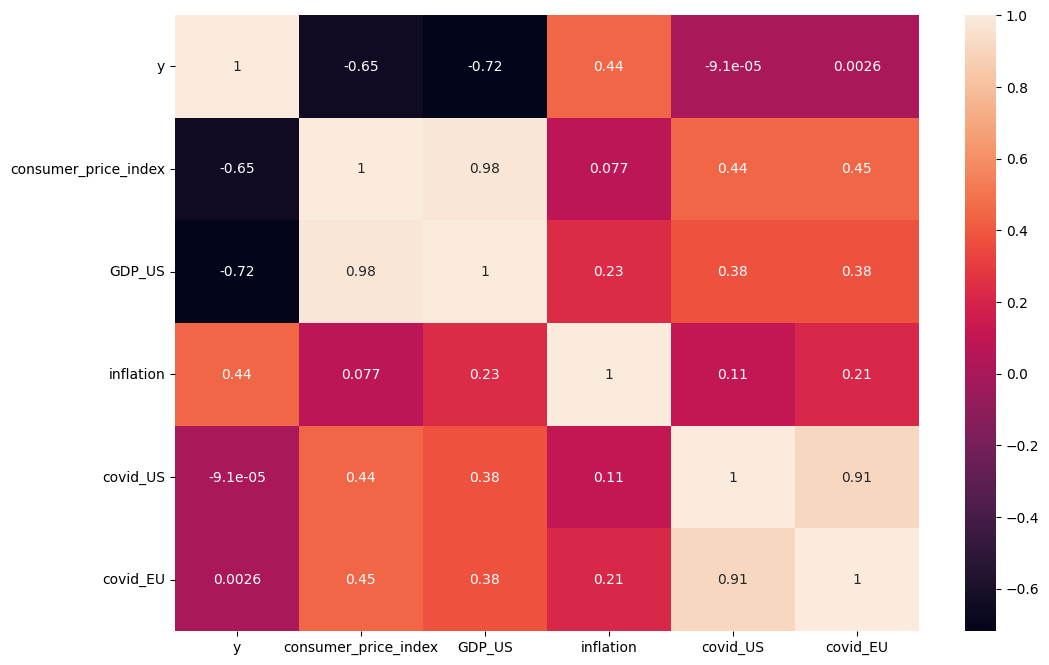

In [128]:
# explore correlation
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(forex_df_reg[['y', 'consumer_price_index', 'GDP_US',
       'inflation', 'covid_US', 'covid_EU']].corr(), annot=True, ax=ax)

### Forecasting using extra regressors with Prophet

# TASK 2: create a new model that exploits external regressors.
* Use function addregressor() to add your regressors and train a new model.
* Explore the usage of from prophet.diagnostics import cross_validation function.
* Create a cross validation experiment with cutoffs of the last 30 steps with initial='1119 days', period='1 days', horizon = '14 days'.
* test on the test dataset as before and evaluate performance metrics

In [129]:
forex_df_reg

ds         y two_weeks_before  consumer_price_index  \
Date                                                                     
2010-01-01 2010-01-01  1.438994       2009-12-18               217.347   
2010-01-04 2010-01-04  1.442398       2009-12-21               217.347   
2010-01-05 2010-01-05  1.436596       2009-12-22               217.347   
2010-01-06 2010-01-06  1.440403       2009-12-23               217.347   
2010-01-07 2010-01-07  1.431803       2009-12-24               217.347   
...               ...       ...              ...                   ...   
2024-05-31 2024-05-31  1.083541       2024-05-17                   NaN   
2024-06-03 2024-06-03  1.085305       2024-05-20                   NaN   
2024-06-04 2024-06-04  1.090739       2024-05-21                   NaN   
2024-06-05 2024-06-05  1.088187       2024-05-22                   NaN   
2024-06-06 2024-06-06  1.087453       2024-05-23                   NaN   

               GDP_US  inflation  covid_US  covid_EU  
Date                                                  
2010-01-01  14628.021        NaN       0.0       0.0  
2010-01-04  14628.021        NaN       0.0       0.0  
2010-01-05  14628.021        NaN       0.0       0.0  
2010-01-06  14628.021        NaN       0.0       0.0  
2010-01-07  14628.021        NaN       0.0       0.0  
...               ...        ...       ...       ...  
2024-05-31        NaN        NaN       0.0       0.0  
2024-06-03        NaN        NaN       0.0       0.0  
2024-06-04        NaN        NaN       0.0       0.0  
2024-06-05        NaN        NaN       0.0       0.0  
2024-06-06        NaN        NaN       0.0       0.0  

[3763 rows x 8 columns]

In [158]:
# Step 1: Define your Prophet model
m = Prophet()

# Step 2: Add external regressors using add_regressor() function
m.add_regressor('consumer_price_index')
m.add_regressor('GDP_US')
m.add_regressor('inflation')
m.add_regressor('covid_US')
m.add_regressor('covid_EU')
m.add_regressor('negative')
m.add_regressor('neutral')
m.add_regressor('positive')


In [150]:
forex_cleaned = forex_df_reg.dropna()

In [67]:
sentiment_df.dtypes

date         object
negative    float64
neutral     float64
positive    float64
ds           object
dtype: object

In [151]:
forex_cleaned.index = pd.to_datetime(forex_cleaned.index, format = '%Y-%m-%d').strftime('%d-%m-%Y')

In [152]:
forex_cleaned["dds"] = forex_cleaned.index

<ipython-input-152-02ba5c688ad7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [155]:
forex_cleaned2 = forex_cleaned.join(sentiment_df, on="dds")

In [160]:
forex_cleaned3 = forex_cleaned2.fillna(0)

In [140]:
sentiment_df.index = sentiment_df["date"]

In [65]:
sentiment_df["ds"] = sentiment_df["date"]
sentiment_df

date  negative   neutral  positive                ds
0     01-01-2021 00:20  0.045591  0.347507  0.002401  01-01-2021 00:20
1     01-01-2021 03:14  0.010174  0.233930  0.006298  01-01-2021 03:14
2     01-01-2024 00:37  0.000055  0.985181  0.010035  01-01-2024 00:37
3     01-01-2024 01:30  0.000189  0.999684  0.000021  01-01-2024 01:30
4     01-02-2021 02:26  0.001550  0.841206  0.002725  01-02-2021 02:26
...                ...       ...       ...       ...               ...
2126  31-10-2023 01:16  0.002908  0.985406  0.000067  31-10-2023 01:16
2127  31-12-2020 02:07  0.000833  0.208067  0.131062  31-12-2020 02:07
2128  31-12-2020 03:15  0.054524  0.350759  0.003904  31-12-2020 03:15
2129  31-12-2021 00:57  0.000121  0.979307  0.003975  31-12-2021 00:57
2130  31-12-2021 02:44  0.001654  0.758539  0.005909  31-12-2021 02:44

[2131 rows x 5 columns]

In [161]:
m.fit(forex_cleaned3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/ugwzxcya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/7rlqvuda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13801', 'data', 'file=/tmp/tmppxxw5525/ugwzxcya.json', 'init=/tmp/tmppxxw5525/7rlqvuda.json', 'output', 'file=/tmp/tmppxxw5525/prophet_modellojbrso9/prophet_model-20240607141553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:15:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [148]:
forex_cleaned['ds'][-114:-14]

Date
16-03-2021   2021-03-16
16-03-2021   2021-03-16
17-03-2021   2021-03-17
17-03-2021   2021-03-17
18-03-2021   2021-03-18
                ...    
21-05-2021   2021-05-21
24-05-2021   2021-05-24
24-05-2021   2021-05-24
25-05-2021   2021-05-25
25-05-2021   2021-05-25
Name: ds, Length: 100, dtype: datetime64[ns]

In [162]:
from prophet.diagnostics import cross_validation
df_cv_14 = cross_validation(m, initial='1119 days', period='1 days', horizon = '14 days', cutoffs = forex_cleaned['ds'][-114:-14])


  0%|          | 0/100 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/11r7ir7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/i_gbi01a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24665', 'data', 'file=/tmp/tmppxxw5525/11r7ir7n.json', 'init=/tmp/tmppxxw5525/i_gbi01a.json', 'output', 'file=/tmp/tmppxxw5525/prophet_modelma9jwmgd/prophet_model-20240607141611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:16:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/dbkzghi8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxxw5525/fi030acx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [163]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_cv_14.index, y=df_cv_14['y'],
                         mode='lines+markers',
                         name='Real Values'))

fig.add_trace(go.Scatter(x=df_cv_14.index, y=df_cv_14['yhat'],
                         mode='lines+markers',
                         name='Predicted Values'))
fig.update_layout(template='plotly_white')
fig.show()

In [164]:
#FILTER
df_cv_14 = df_cv_14.loc[(df_cv_14['ds'] - df_cv_14['cutoff']).dt.days == 14]

In [167]:
df_cv_14

ds      yhat  yhat_lower  yhat_upper         y     cutoff
18   2021-01-11  1.229488    1.217834    1.240075  1.218621 2020-12-28
19   2021-01-11  1.229530    1.218585    1.240068  1.218621 2020-12-28
38   2021-01-12  1.234461    1.223576    1.245362  1.216070 2020-12-29
39   2021-01-12  1.234508    1.224037    1.245193  1.216070 2020-12-29
58   2021-01-13  1.240482    1.230228    1.251455  1.220889 2020-12-30
...         ...       ...         ...         ...       ...        ...
1949 2021-05-26  1.199573    1.188155    1.211017  1.224909 2021-05-12
1968 2021-05-27  1.202036    1.190886    1.213154  1.219260 2021-05-13
1969 2021-05-27  1.202130    1.189786    1.214102  1.219260 2021-05-13
1988 2021-05-28  1.205319    1.192837    1.217059  1.219319 2021-05-14
1989 2021-05-28  1.205619    1.193580    1.217270  1.219319 2021-05-14

[199 rows x 6 columns]

In [165]:
#MERGE OF THE DATASETS
merged_df = pd.merge(df_cv_14,forex_df_reg , left_on = 'cutoff', right_on='ds')
merged_df

ds_x      yhat  yhat_lower  yhat_upper       y_x     cutoff  \
0   2021-01-11  1.229488    1.217834    1.240075  1.218621 2020-12-28   
1   2021-01-11  1.229530    1.218585    1.240068  1.218621 2020-12-28   
2   2021-01-12  1.234461    1.223576    1.245362  1.216070 2020-12-29   
3   2021-01-12  1.234508    1.224037    1.245193  1.216070 2020-12-29   
4   2021-01-13  1.240482    1.230228    1.251455  1.220889 2020-12-30   
..         ...       ...         ...         ...       ...        ...   
194 2021-05-26  1.199573    1.188155    1.211017  1.224909 2021-05-12   
195 2021-05-27  1.202036    1.190886    1.213154  1.219260 2021-05-13   
196 2021-05-27  1.202130    1.189786    1.214102  1.219260 2021-05-13   
197 2021-05-28  1.205319    1.192837    1.217059  1.219319 2021-05-14   
198 2021-05-28  1.205619    1.193580    1.217270  1.219319 2021-05-14   

          ds_y       y_y two_weeks_before  consumer_price_index     GDP_US  \
0   2020-12-28  1.220510       2020-12-14               261.560  21494.731   
1   2020-12-28  1.220510       2020-12-14               261.560  21494.731   
2   2020-12-29  1.222345       2020-12-15               261.560  21494.731   
3   2020-12-29  1.222345       2020-12-15               261.560  21494.731   
4   2020-12-30  1.225295       2020-12-16               261.560  21494.731   
..         ...       ...              ...                   ...        ...   
194 2021-05-12  1.214450       2021-04-28               266.832  22048.894   
195 2021-05-13  1.207851       2021-04-29               266.832  22048.894   
196 2021-05-13  1.207851       2021-04-29               266.832  22048.894   
197 2021-05-14  1.207729       2021-04-30               266.832  22048.894   
198 2021-05-14  1.207729       2021-04-30               266.832  22048.894   

     inflation  covid_US  covid_EU  
0         1.88  214389.0  158835.0  
1         1.88  214389.0  158835.0  
2         1.91  232025.0  213495.0  
3         1.91  232025.0  213495.0  
4         1.92  270226.0  241622.0  
..         ...       ...       ...  
194       2.41   74410.0  161802.0  
195       2.42   81146.0  155986.0  
196       2.42   81146.0  155986.0  
197       2.41   77742.0  131930.0  
198       2.41   77742.0  131930.0  

[199 rows x 14 columns]

Mean MAE: 0.02
MAE%: 1.52%
RMSE: 0.02
Bias: 0.00

5th percetile MAE: 0.00
25th percetile MAE: 0.01
50th percetile MAE: 0.02
75th percetile MAE: 0.02
95th percetile MAE: 0.04


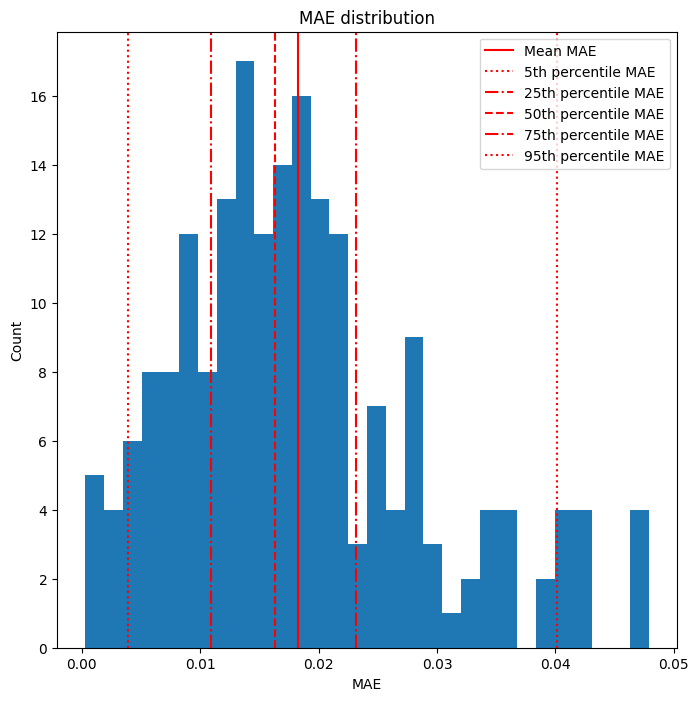

In [168]:
calc_errors(df_cv_14.y, df_cv_14.yhat)

In [166]:
merged_df['difference'] = merged_df['y_x'] - merged_df['y_y'].shift(1)
merged_df['difference'] = merged_df['y_x'] - merged_df['y_x'].shift(1)
merged_df

ds_x      yhat  yhat_lower  yhat_upper       y_x     cutoff  \
0   2021-01-11  1.229488    1.217834    1.240075  1.218621 2020-12-28   
1   2021-01-11  1.229530    1.218585    1.240068  1.218621 2020-12-28   
2   2021-01-12  1.234461    1.223576    1.245362  1.216070 2020-12-29   
3   2021-01-12  1.234508    1.224037    1.245193  1.216070 2020-12-29   
4   2021-01-13  1.240482    1.230228    1.251455  1.220889 2020-12-30   
..         ...       ...         ...         ...       ...        ...   
194 2021-05-26  1.199573    1.188155    1.211017  1.224909 2021-05-12   
195 2021-05-27  1.202036    1.190886    1.213154  1.219260 2021-05-13   
196 2021-05-27  1.202130    1.189786    1.214102  1.219260 2021-05-13   
197 2021-05-28  1.205319    1.192837    1.217059  1.219319 2021-05-14   
198 2021-05-28  1.205619    1.193580    1.217270  1.219319 2021-05-14   

          ds_y       y_y two_weeks_before  consumer_price_index     GDP_US  \
0   2020-12-28  1.220510       2020-12-14               261.560  21494.731   
1   2020-12-28  1.220510       2020-12-14               261.560  21494.731   
2   2020-12-29  1.222345       2020-12-15               261.560  21494.731   
3   2020-12-29  1.222345       2020-12-15               261.560  21494.731   
4   2020-12-30  1.225295       2020-12-16               261.560  21494.731   
..         ...       ...              ...                   ...        ...   
194 2021-05-12  1.214450       2021-04-28               266.832  22048.894   
195 2021-05-13  1.207851       2021-04-29               266.832  22048.894   
196 2021-05-13  1.207851       2021-04-29               266.832  22048.894   
197 2021-05-14  1.207729       2021-04-30               266.832  22048.894   
198 2021-05-14  1.207729       2021-04-30               266.832  22048.894   

     inflation  covid_US  covid_EU  difference  
0         1.88  214389.0  158835.0         NaN  
1         1.88  214389.0  158835.0    0.000000  
2         1.91  232025.0  213495.0   -0.002550  
3         1.91  232025.0  213495.0    0.000000  
4         1.92  270226.0  241622.0    0.004819  
..         ...       ...       ...         ...  
194       2.41   74410.0  161802.0    0.000000  
195       2.42   81146.0  155986.0   -0.005650  
196       2.42   81146.0  155986.0    0.000000  
197       2.41   77742.0  131930.0    0.000059  
198       2.41   77742.0  131930.0    0.000000  

[199 rows x 15 columns]

DAY 2


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/

/content/drive/MyDrive/Colab_Notebooks


In [ ]:
!mkdir NLP_MASTER

In [ ]:
pip install -U spacy Tranformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 18.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement Tranformers (from versions: none)
ERROR: No matching distribution found for Tranformers
